In [2]:
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap
from shapely.geometry import mapping
from rasterio import mask as msk
import geopandas as gpd
import pandas as pd
from pathlib import Path
import xarray as xr

# cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'

##### extracting data

In [3]:
tif_file_world = rasterio.open(data_path/'population_files'/'GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif')

ghs_world = tif_file_world.read()

In [4]:
df = gpd.read_file(data_path / 'population_files' / 'NaturalEarth' / 'ne_10m_admin_0_countries.shp')
western_europe = df.loc[df['ADMIN'].isin(['United Kingdom', 'Germany', 'Austria', 'Czechia',
                                          'Italy', 'Denmark', 'Luxembourg',
                                          'Belgium', 'Switzerland', 'Ireland',
                                          'Iceland', 'Norway', 'Sweden',
                                          'Finland', 'Estonia', 'Latvia', 'Lithuania',
                                          'Poland', 'Slovakia', 'Hungary', 'Slovenia',
                                          'Croatia', 'Bosnia and Herzegovina', 'Serbia',
                                          'Montenegro', 'Kosovo', 'Albania', 'Macedonia',
                                          'Greece', 'Bulgaria', 'Romania', 'Moldova',
                                          'Tunisia', 'Morocco', 'Algeria', 'Libya', 'Egypt',
                                          'Belarus', 'Ukraine', 'Serbia'])]

# For each country, create a new GeoDataFrame with the desired geometry
def update_geometry(country_df, index):
    if not country_df.empty:
        geom = country_df.iloc[0].geometry
        # Check if the geometry is a MultiPolygon and has enough elements
        if geom.type == 'MultiPolygon' and len(geom.geoms) > index:
            # Access the specific Polygon within the MultiPolygon
            selected_geom = [geom.geoms[index]]
            return gpd.GeoDataFrame(country_df, geometry=selected_geom)
    return country_df

france = update_geometry(df.loc[df['ADMIN'] == 'France'], 1)
spain = update_geometry(df.loc[df['ADMIN'] == 'Spain'], 2)
netherlands = update_geometry(df.loc[df['ADMIN'] == 'Netherlands'], 0)
portugal = update_geometry(df.loc[df['ADMIN'] == 'Portugal'], 0)

# Concatenate all GeoDataFrames
western_europe = pd.concat([western_europe, france, spain, netherlands, portugal])

C:\Users\kirst\AppData\Local\Temp\ipykernel_29272\743294995.py:19: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom.type == 'MultiPolygon' and len(geom.geoms) > index:


In [5]:
europe_array, clipped_transform = msk.mask(tif_file_world, [mapping(geom) for geom in western_europe.geometry.tolist()], crop=True)

##### Plotting w cartopy - europe

In [6]:
our_cmap = cm.get_cmap('binary', 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([1, 1, 1, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

C:\Users\kirst\AppData\Local\Temp\ipykernel_29272\4113049895.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  our_cmap = cm.get_cmap('binary', 10)


In [7]:
# finding limits of europe_array
lat_min = clipped_transform[2]
lat_max = clipped_transform[2] + clipped_transform[0]*europe_array.shape[2]
lon_min = clipped_transform[5] + clipped_transform[4]*europe_array.shape[1]
lon_max = clipped_transform[5]

print(lat_min, lat_max, lon_min, lon_max)

# lat_min, lat_max, lon_min, lon_max = -24.541249880403143, 18.842083281098283, 35.482916726764095, 66.56624993499972
print(lat_min, lat_max, lon_min, lon_max)

-24.541249880403143 40.16708319663462 -54.46708291122391 80.77458321115031
-24.541249880403143 40.16708319663462 -54.46708291122391 80.77458321115031


C:\Users\kirst\AppData\Local\Temp\ipykernel_29272\2860140244.py:31: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(f), origin="lower", extent=img_extent, transform=ccrs.PlateCarree())


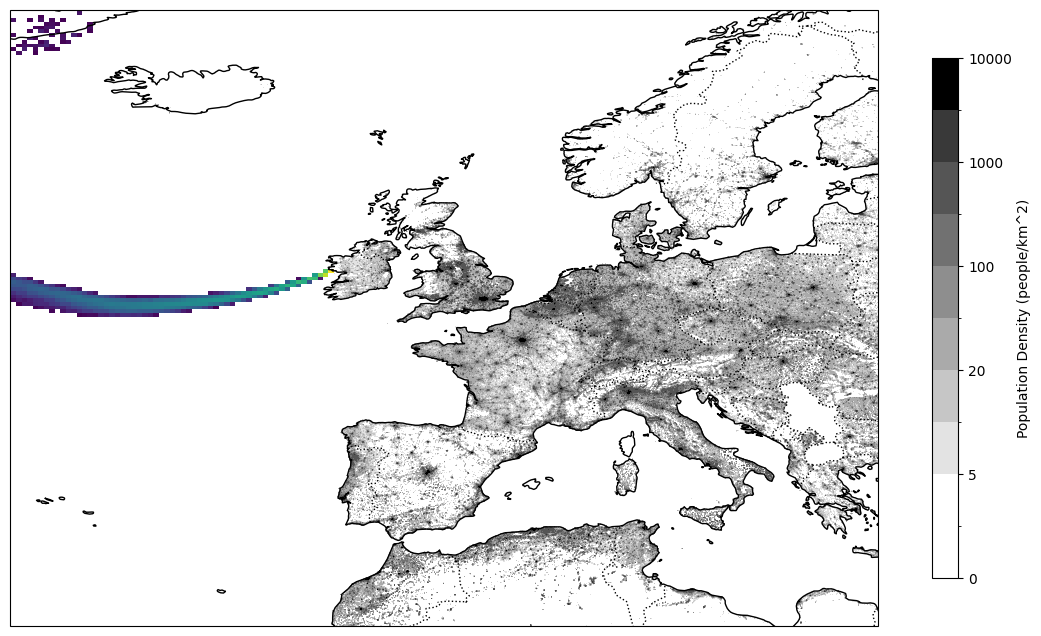

In [15]:
# Create the plot
fig, ax = plt.subplots(facecolor='#FFFFFF', subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 9))

# Set the extent
ax.set_extent([lat_min-6, lat_max-15, lon_min+85, lon_max-13])

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Display the image
im = ax.imshow(europe_array[0], norm=norm, cmap=our_cmap, extent=[lat_min, lat_max, lon_min, lon_max], zorder=0)

# Add a colorbar for the image
cbar = fig.colorbar(im, ax=ax, shrink=0.75, label='Population Density (people/km^2)')

ax.set_aspect('auto')


# adding footprint
fp = xr.open_dataset(data_path /'NAME'/ 'MHD-10magl_UKV_EUROPE_202001.nc')
img_extent = (fp.lon[0], fp.lon[-1], fp.lat[0], fp.lat[-1])

idx = 350
clean=True

f = np.copy(fp.fp[:,:,idx].values)
if clean:
    f[f<0.0005] = 0

ax.imshow(np.log10(f), origin="lower", extent=img_extent, transform=ccrs.PlateCarree())